# Nobigi - Neural optimized baked interactive global illumination

The following is a step by step guide to train small neural networks to be used in shaders as a way to provide performant baked but interactive global illumination in WebGL2 scenes.

# 1. Dependencies 
First we install dependencies and check system info:

In [1]:
!pip install tensorflow-graphics --quiet

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)



     |████████████████████████████████| 4.3 MB 14.6 MB/s 
     |████████████████████████████████| 659 kB 68.4 MB/s 
     |████████████████████████████████| 281 kB 79.8 MB/s 
     |████████████████████████████████| 1.1 MB 59.9 MB/s 
Thu Sep 22 09:01:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|               

# 2. Dataset upload
Next we upload the zip file containing the images we'd like to use as a training set (see https://github.com/jure/nobigi/tree/main/data/coffee_cup.zip for an example):

In [2]:
from google.colab import files
from zipfile import ZipFile
import shutil

try: 
  shutil.rmtree('dataset')
except:
  print('No dataset dir')

uploaded = files.upload() 
filename = next(iter(uploaded.keys()))
zip = ZipFile(filename)
zip.extractall('dataset')
print('Done')

imageSize = 512

No dataset dir


Saving ddCoffee Cup_+1.57079649_+1.17809737.zip to ddCoffee Cup_+1.57079649_+1.17809737.zip
Done


# 3. Dataset check
Ensure that we have only images in our dataset:

In [3]:
from pathlib import Path
import imghdr
import shutil
import sys,os,re

data_dir = "dataset"
# shutil.rmtree('dataset/__MACOSX')
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


# 4. Dataset preparation/reshaping

Then we reshape all images into tensors, in such a way, that the input dataset is x, y, and two custom floats (in our example these are the rotations of the light in the scene, but could be any dynamic component) and the sought after output is matching r, g and b values.

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_graphics.geometry.representation.grid as grid
from tensorflow import keras
from tensorflow.keras import layers
from array import array
import math
import time

dataset = tf.keras.utils.image_dataset_from_directory(
  'dataset',
  image_size=(imageSize, imageSize),
  label_mode=None,
  batch_size=None,
  shuffle=False
)
    
file_paths = dataset.file_paths

# Extract the rotations from the filenames, where they are encoded, e.g.:
# "Coffee Cup_+1.57079649_+1.17809737.jpg"
w = list(map(
    lambda file: list(map(
        lambda coord: math.copysign(float(coord) % math.pi, float(coord)), 
        file.replace('.jpg','').split('_')[1:3])), 
    dataset.file_paths))

def normalizeLA(entry):
  normalized0 = (entry[0] % math.pi ) / math.pi
  normalized1 = (entry[1] % math.pi ) / math.pi
  return [normalized0, normalized1]

w = list(map(normalizeLA, w))
print(w)
print(len(w))
inputs = [ ]

for i, light_angles in enumerate(w):
  print(i, end="\r")

  inputs_sample = grid.generate((0., 0.), (1., 1.), (imageSize, imageSize))
  inputs_sample = tf.reshape(inputs_sample, [imageSize * imageSize,2])

  angle_array_1 = np.full((imageSize * imageSize), light_angles[0])
  angle_array_2 = np.full((imageSize * imageSize), light_angles[1])
  inputs_sample = np.column_stack((inputs_sample, angle_array_1))
  inputs_sample = np.column_stack((inputs_sample, angle_array_2))

  inputs.append(inputs_sample)
 
input_ds = tf.data.Dataset.from_tensor_slices(inputs)

normalization_layer = layers.Rescaling(1./255)
print('Normalizing dataset')
normalized_ds = dataset.map(lambda x: (normalization_layer(x)))

# Stretch out the tensor into a simple flat list of RGB values
print('Reshaping dataset')
flattened_ds = normalized_ds.map(lambda x: (tf.reshape(x, [imageSize*imageSize,3])))

print('Zipping dataset')
flattened_ds = tf.data.Dataset.zip((input_ds, flattened_ds))

Found 420 files belonging to 1 classes.
[[0.38124992704938737, 0.37500000156093677], [0.38124996524657373, 0.12499999309308159], [0.38124996524657373, 0.2999999694177608], [0.38124996524657373, 0.4249999847925344], [0.3812500034437601, 0.04999999596399309], [0.3812500034437601, 0.0750000130445828], [0.3812500034437601, 0.2250000168520564], [0.3812500034437601, 0.2500000084678552], [0.3812500034437601, 0.274999977801962], [0.3812500034437601, 0.3249999801321528], [0.3812500034437601, 0.3500000290437312], [0.3812500034437601, 0.45000003052101395], [0.3812500034437601, 0.5000000519497979], [0.38125004164094645, 0.0], [0.38125004164094645, 0.02500000434819427], [0.38125004164094645, 0.10000000147728276], [0.38125004164094645, 0.15000000380747358], [0.38125004164094645, 0.1750000145218656], [0.38125004164094645, 0.20000000613766442], [0.38125004164094645, 0.40000001227532883], [0.38125004164094645, 0.4750000412354059], [0.38749996712939705, 0.3249999801321528], [0.38749996712939705, 0.49999

# 5. Neural network setup

The network here consists of sine activated layers (see https://www.vincentsitzmann.com/siren/ for more information). This network has a crucial hyperparameter `first_w` - its optimal value depends on the nature of the image, intuitively an image with more detail will need a higher `first_w`. Values 10 to 30 are good ones to try first.

This network additionally uses skip connections, but in a funky sort of way, where the weight for each skip connection is diminishing with depth. That idea was adapted from Blackle Mori's work on its Neural Bunny (https://www.shadertoy.com/view/wtVyWK), where it uses a sqrt of depth - we use an arbitrary but decreasing value, since it performed better.  

In [5]:
import tensorflow as tf
from tensorflow import keras
import math

first_w = 20
hidden_w = 30
neurons = 32

class SineLayer(tf.keras.layers.Layer):
    def __init__(self, out_features, bias=True, omega_0=30, kernel_initializer=None, has_skip=False, skip_idx=1):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = tf.keras.layers.Dense(
            out_features, use_bias=bias, kernel_initializer=kernel_initializer
        )
        self.has_skip = has_skip
        self.skip_idx = skip_idx

    def call(self, input):
        intermediate = tf.sin(self.omega_0 * self.linear(input))
        if self.has_skip:
          intermediate = intermediate / self.skip_idx + input
        return intermediate

# Custom metric for learning rate
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

model = keras.models.Sequential()
first_initializer = tf.keras.initializers.RandomUniform(
    minval=(- 1 / 4), 
    maxval=(+ 1 / 4)
)

initializer = tf.keras.initializers.RandomUniform(
    minval=(-math.sqrt(6/neurons) / (hidden_w)), 
    maxval=(+math.sqrt(6/neurons) / (hidden_w))
)

model.add(SineLayer(neurons, omega_0=first_w, kernel_initializer=first_initializer))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=1))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=1))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=2))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=3))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=4))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=5))
model.add(SineLayer(neurons, omega_0=hidden_w, kernel_initializer=initializer, has_skip=True, skip_idx=6))

# output layer
model.add(keras.layers.Dense(3, kernel_initializer=initializer))  

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.97)


first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.optimizers.schedules.CosineDecayRestarts(
      1e-4,
      first_decay_steps))

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)

model.compile(loss= "mean_squared_error" , optimizer=optimizer, metrics=["mean_squared_error", lr_metric])

# 6. Training

Time for training.

In [6]:
epochs = 100

fit_ds = flattened_ds.shuffle(buffer_size=420)
fit_ds.repeat()

history = model.fit(
  fit_ds,
  epochs=epochs,
)

model.summary()

Epoch 1/100
420/420 [==============================] - 11s 16ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - lr: 9.9362e-05
Epoch 2/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - lr: 9.8099e-05
Epoch 3/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - lr: 9.6852e-05
Epoch 4/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 9.5620e-05
Epoch 5/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - lr: 9.4405e-05
Epoch 6/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - lr: 9.3205e-05
Epoch 7/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - lr: 9.2020e-05
Epoch 8/100
420/420 [==============================] - 7s 16ms/step - loss: 0.0021 - mean_square

# 7. Testing/rendering a few examples

The following does inference on a few example angles, calculates the PSNR and shows the resulting images.

[0.38124996524657373, 0.12499999309308159]
dataset/ddCoffee Cup_+1.19773209_+0.39269906.jpg
tf.Tensor(12.096568, shape=(), dtype=float32)
[0.38750000532658335, 0.37500000156093677]
dataset/ddCoffee Cup_+1.21736717_+1.17809725.jpg
tf.Tensor(11.563501, shape=(), dtype=float32)
[0.40000001227532883, 0.2500000434819427]
dataset/ddCoffee Cup_+1.25663710_+0.78539830.jpg
tf.Tensor(12.541427, shape=(), dtype=float32)


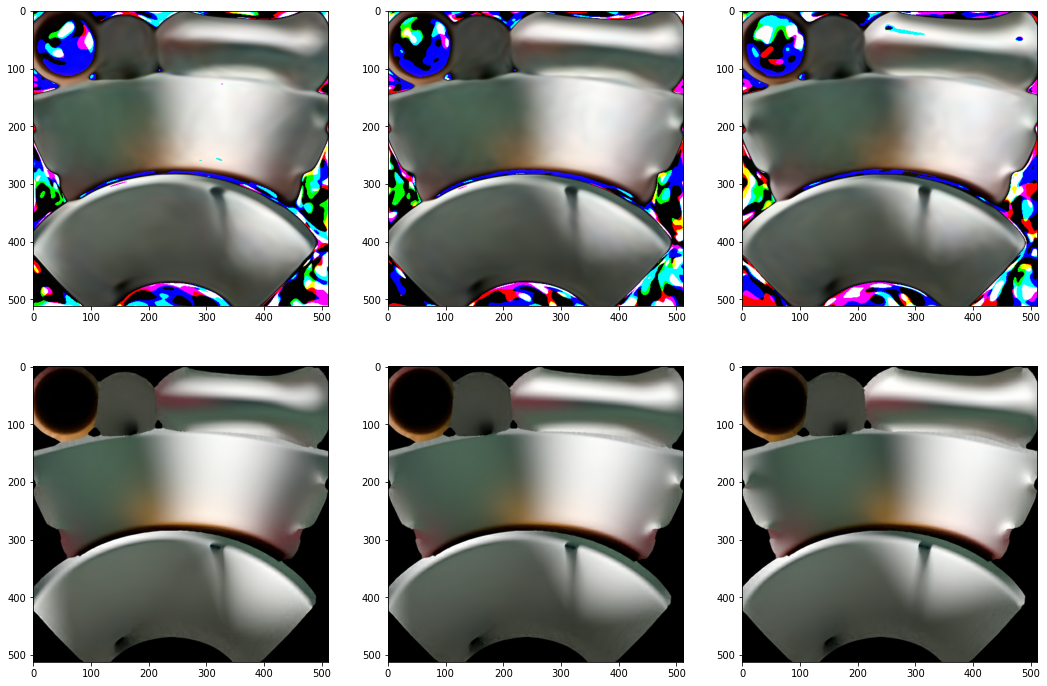

In [7]:
import matplotlib.pylab as plt

# Let's try to 'render' it back
all = True
def makeImage(num):
  print(w[num])
  print(file_paths[num])

  inputs_sample = grid.generate((0., 0.), (1., 1.), (imageSize, imageSize))
  inputs_sample = tf.reshape(inputs_sample, [imageSize * imageSize,2])

  angle_array_1 = np.full((imageSize * imageSize), w[num][0])
  angle_array_2 = np.full((imageSize * imageSize), w[num][1])
  render = np.column_stack((inputs_sample, angle_array_1))
  render = np.column_stack((render, angle_array_2))

  render = model.predict(render)
  render = (render * 255).astype(int)
  render= tf.cast(render, tf.uint8)
  # print(render)
  tensor_image = tf.convert_to_tensor(render)

  tensor_image = tf.reshape(tensor_image, [imageSize, imageSize, 3])

  img_raw = tf.io.read_file(file_paths[num])
  img = tf.io.decode_image(img_raw)
  img = tf.image.convert_image_dtype(img, tf.uint8)

  # print(img)
  return [tensor_image, img]

fig, axs = plt.subplots(2,3, figsize=(18,12))

if all:
  [i1, i2] = makeImage(1)
  psnr1 = tf.image.psnr(i1, i2, max_val=255)
  print(psnr1)
  axs[0,0].imshow(i1)
  axs[1,0].imshow(i2)

  [i5, i6] = makeImage(30)
  psnr1 = tf.image.psnr(i5, i6, max_val=255)
  print(psnr1)
  axs[0,2].imshow(i5)
  axs[1,2].imshow(i6)

[i3, i4] = makeImage(79)
psnr1 = tf.image.psnr(i3, i4, max_val=255)
print(psnr1)
axs[0,1].imshow(i3)
axs[1,1].imshow(i4)

plt.show()

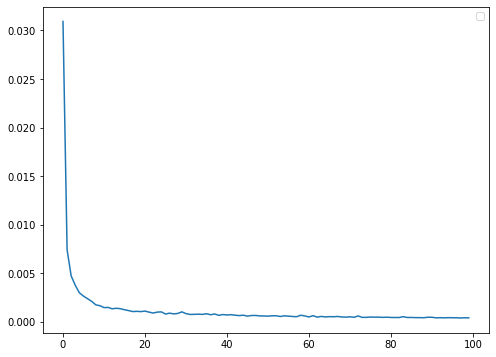

In [8]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))

plt.plot(history.history['loss'])
plt.legend()

# 8. Converting the network to GLSL code

The code below will convert the neural network's layers into optimized shader code, using a technique shown by Blackle in Neural Stanford Bunny (https://www.shadertoy.com/view/wtVyWK). The representation here is adapted to accommodate 4 inputs. There are other ways to represent neural networks in GLSL, but we found that this approach is optimal, since it does not suffer from long shader compilation times on platforms using ANGLE with Direct3D underneath, such as browsers on Windows.

The conversion code is adapted from Peter Knight's Colab notebook which ported Blackle's work to Tensorflow (https://colab.research.google.com/github/going-digital/ml_sdf/blob/main/ml_sdf.ipynb), but with an added input layer and support for skip connections.



In [13]:
def model_to_shadertoy(model):
    out = "vec3 scene(vec4 p) {\n"
    out += "  vec4 "
    vec4_defs = ["x=p"]
    
    layers = len(model.weights) // 2
    
    def vec4(n):
        return 'vec4(' + ','.join(['{0:.3f}'.format(i) for i in n.flatten()]) + ')'

    def mat4(n, transpose=False):
        if transpose: n = np.transpose(n)
        return 'mat4(' + ','.join(['{0:.3f}'.format(i) for i in n.flatten()]) + ')'

    def vname(layer, chunk):
        return "f%d%d" % (layer, chunk)

    # First layer
    input_dim, output_dim = model.weights[0].shape
    assert(output_dim % 4 == 0)
    w0 = first_w
    for chunk in range(output_dim // 4):
        mat = np.concatenate([
            w0*model.weights[0][0, chunk*4:4+chunk*4],
            w0*model.weights[0][1, chunk*4:4+chunk*4],
            w0*model.weights[0][2, chunk*4:4+chunk*4],
            w0*model.weights[0][3, chunk*4:4+chunk*4]
        ]).reshape(4,4)
        vec4_defs.append(
            '{}=sin(x*{} + {})'.format(
                vname(0,chunk),
                mat4(mat, transpose=True),
                vec4(w0*model.weights[1][chunk*4:4+chunk*4].numpy())
            )
        )
    
    # Hidden layers
    for layer in range(1, layers-1):
        w0 = hidden_w
        input_dim, output_dim = model.weights[2*layer].shape
        assert(input_dim % 4 == 0)
        assert(output_dim % 4 == 0)
        for out_chunk in range(output_dim // 4):
            elements = []
            for in_chunk in range(input_dim // 4):
                elements.append(
                    mat4(w0*model.weights[2*layer][in_chunk*4:4+in_chunk*4, out_chunk*4:4+out_chunk*4].numpy(), transpose=False)
                    + '*'
                    + vname(layer-1, in_chunk)
                )
            elements.append(
                vec4(w0*model.weights[2*layer+1][out_chunk*4:4+out_chunk*4].numpy())
            )
            vec4_defs.append(
                '{}=sin({})/{}'.format(
                    vname(layer, out_chunk),
                    '+'.join(elements),
                    "%0.3f+%s"%(model.layers[layer].skip_idx, vname(layer-1, out_chunk))
                )
            )
        
    # Build into first statement
    out += ',\n  '.join(vec4_defs) + ";\n"

    # Output layer is separate return statement
    layer = layers - 1
    elements = []
    input_dim, output_dim = model.weights[2*layer].shape
    assert(input_dim % 4 == 0)
    w0 = hidden_w
    
    out += "  vec3 r = vec3("
    for out_chunk in range(output_dim):
      elements = []
      for in_chunk in range(input_dim // 4):
          weights = model.weights[2*layer][4*in_chunk:4+4*in_chunk].numpy()
          weightsForOut =  weights[:,out_chunk]
          # print(weightsForOut)
          elements.append(
              "dot({},{})".format(
                  vec4(weightsForOut),
                  vname(layer - 1, in_chunk)
              )
          )
      elements.append("{0:.3f}".format(model.weights[2*layer+1][out_chunk]))
      out += "+".join(elements)
      if out_chunk < output_dim - 1:
        out += ","
    
    out += ");\n  return r;\n}\n"

    # Simplifying substitutions
    out = re.sub(r"(\d+\.\d*)0+\b", r"\1", out) # Remove trailing zeros eg. 1.0 => 1.
    out = re.sub(r"\b(\.\d+)0+\b", r"\1", out) # Remove trailing zeros eg. .60 => .6
    out = re.sub(r"\b0(\.\d+)\b", r"\1", out) # Remove leading zeros eg. 0.5 => .5
    out = re.sub(r"-\.0+\b", r".0", out) # Make all zeros positive eg. -.0 => .0
    out = re.sub(r"\+-", r"-", out) # Change +-1. into -1.

    return out
    
print('// Loss: ', float(model.metrics[1].result()))
print(model_to_shadertoy(model))

print(hidden_w, first_w)

// Loss:  0.0004127100692130625
vec3 scene(vec4 p) {
  vec4 x=p,
  f00=sin(x*mat4(5.139,-1.988,-4.548,1.179,-.899,2.474,-2.163,1.06,4.858,-3.08,4.281,-.494,-3.096,-3.898,-4.805,1.946) + vec4(.045,.082,-.16,-.111)),
  f01=sin(x*mat4(.385,.088,-.057,.878,-.035,1.286,1.326,-3.306,1.234,4.404,-4.215,-3.702,4.866,-3.167,-3.368,1.584) + vec4(-.329,-.128,-.234,-.099)),
  f02=sin(x*mat4(1.581,-5.036,.12,-2.118,3.111,-3.755,-2.167,-1.777,3.792,-1.731,.308,1.872,1.522,-2.1,.282,-2.858) + vec4(-.047,-.05,.023,-.016)),
  f03=sin(x*mat4(4.584,-1.956,-3.271,1.808,-1.664,-.44,-1.754,-1.794,-1.444,4.163,-1.507,-1.837,-3.979,4.709,-1.695,-1.453) + vec4(.064,-.102,-.245,.18)),
  f04=sin(x*mat4(4.88,4.204,2.355,3.039,.507,3.794,-2.81,1.164,5.13,3.979,2.628,-1.08,-5.089,2.983,.03,1.311) + vec4(-.024,-.12,-.16,.241)),
  f05=sin(x*mat4(-5.01,-3.041,-.439,2.38,-.061,2.349,-2.219,1.929,-4.839,4.509,.352,2.631,-.029,2.519,3.839,-1.639) + vec4(.09,.06,.019,.077)),
  f06=sin(x*mat4(4.368,2.61,-1.87,1.523,.359,-1

# 9. All done!

You can check out a live example of this in CodeSandbox: https://codesandbox.io/s/nobigi-coffee-cup-example-xtj3tk

For more detail check the [Nobigi Github repository](https://github.com/jure/nobigi), and perhaps also read the note describing the origin of the approach: https://juretriglav.si/compressing-global-illumination-with-neural-networks/